<a href="https://colab.research.google.com/github/iProlly/Comchem/blob/main/ML_Mixture_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This file is only for machine learning: mixture detection
---
\
There is no augmentation components in this file. If you want to do augmentation, make sure to go to Augmentation Command.ipynb. This file is only to detect what compound is in mixture detection. If you want to just specify the compound, go to other .ipynb.

We only accept 1 type of input: It must be only 1 file, containing labels at the most left, and feature. it also **must** have header. See example below.

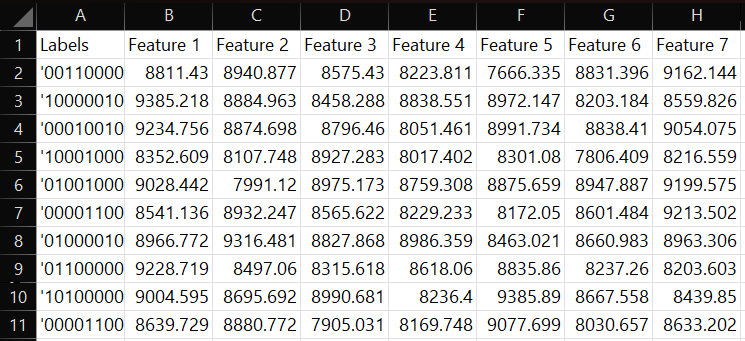

**Important** you must know what index correspond to what compound. you should obtain it in augmentation command. For example,

**['Eugenol', 'Trans-anethole', 'Cinnamaldehyde', 'Ethyl-benzoate', 'Methyl-salicylate', 'Benzaldehyde', 'Carvone', 'Limonene']**


**If you dont know, you must do augmentation all over again.**

you can adjust parameters in the second cell, then you are ready to go!

In [ ]:
# Import modules (tools) that you have to use
import pandas as pd
import numpy as np
import os
from google.colab import drive
from random import randrange
import matplotlib.pyplot as plt
import io
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Parameters

# Compound_list is the list of compound that you obtained while augmentation. It tells us each index correspond to what commpound
compound_list = [''] + ['Eugenol', 'Trans-anethole', 'Cinnamaldehyde', 'Ethyl-benzoate', 'Methyl-salicylate', 'Benzaldehyde', 'Carvone', 'Limonene']

# Choose compounds you want to detect by choosing its index from 1 - 8 (see compound_list)
# We will also print compound you want to detect, see if it is your need. Please remember this list, so that you can read the results.
index_test = [2,4,6]
print([compound_list[i] for i in index_test])

# Set the number of samples we want to remove from data, to test the model after it is finished
# The number must be less than the number of samples you have in the file.
testing_number = 750

# File name
file_name = 'TEST.csv'

['Trans-anethole', 'Ethyl-benzoate', 'Benzaldehyde']


In [ ]:
# Import data from the .csv file, you may change file name to suit your data
raw = pd.read_csv('/content/' + file_name)

# From raw (the data we just import), take first column as a label, and others as data
label = raw.iloc[:, 0].values
labels = []
for i in range(len(label)):
  text = ''
  for j in index_test:
    text += label[i][j]
  labels.append(text)
labels = np.array(labels)
data = raw.iloc[:, 1:].values

# Generate random indices to pick samples for testing
random_indices = np.random.choice(len(data), testing_number, replace=False)

# Select testing data and labels
testing_data = data[random_indices]
testing_labels = labels[random_indices]

# Remove the selected indices from the main dataset
data = np.delete(data, random_indices, axis=0)
labels = np.delete(labels, random_indices, axis=0)

# Convert to NumPy arrays if needed
testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)

# Encode labels to make it understandable for computer
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [ ]:
# Split the data into training and validation (internal testing) sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.3, random_state=42)

# Add channel dimension for CNN, because original data format is not usable for computer.
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
testing_data = testing_data[..., np.newaxis]

In [ ]:
# Create neural network model by constructing layers
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(data.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Use this model to train, and evaluate the model by some specific parameters (here use adam optimizer, crossentropy loss, and accuracy metric)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.3909 - loss: 2213.4839 - val_accuracy: 0.8113 - val_loss: 4.8066
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.8192 - loss: 2.3121 - val_accuracy: 0.8041 - val_loss: 1.3952
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.8503 - loss: 1.0811 - val_accuracy: 0.8472 - val_loss: 1.4462
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.8820 - loss: 0.7127 - val_accuracy: 0.8390 - val_loss: 1.3507
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9335 - loss: 0.3232 - val_accuracy: 0.8533 - val_loss: 0.9682


In [ ]:
# Check out performance of model throughout training process
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8521 - loss: 0.8910
Test accuracy: 85.33%


In [ ]:
# Use the finished model to evaluate a set of data that we originally pull out
prediction = model.predict(testing_data)
predicted_class_index = np.argmax(prediction, axis=1)
predicted_class = label_encoder.inverse_transform(predicted_class_index)

# Evaluate perfomance of model from predicting testing data
point = 0
for i in range(len(predicted_class)):
  if predicted_class[i] == testing_labels[i]:
    point+=1
print("Percentage accuracy:", point/len(predicted_class)*100)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Percentage accuracy: 84.26666666666667


Confusion Matrix in Table Format:
     000  001  010  011  100  101  110
000  228   13   24    0    6    0    0
001    4  120    0    4    1    2    0
010   32    3   95    4    0    0    0
011    0    6    0   19    0    0    0
100    5    1    2    0  124    0    0
101    0    0    0    1    5   24    0
110    1    0    0    0    4    0   22


<Figure size 800x600 with 0 Axes>

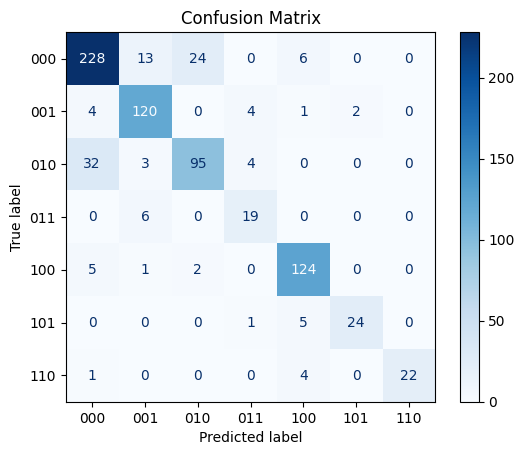

In [ ]:
# Set up confusion matrix for testing data
# Row = True labels, Column = Predicted labels
conf_matrix = confusion_matrix(testing_labels, predicted_class, labels=np.unique(labels))

# Display the confusion matrix as a formatted table
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)
print("Confusion Matrix in Table Format:")
print(conf_matrix_df)

# Display the confusion matrix as a grid color
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()